In [ ]:
from google.colab import files
import io
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
from sklearn import metrics
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPool1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from collections import Counter
from collections import Counter
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB 
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
# Importing libraries for cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [106]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/creditcard.csv')

In [ ]:
df.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,-0.915427,-1.040458,-0.031513,-0.188093,-0.084316,0.041333,-0.302620,-0.660377,0.167430,-0.256117,0.382948,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


In [ ]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

#Data Preprocessing

In [ ]:
# df.drop('Time', axis=1, inplace=True)

##Feature Scaling

In [107]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df['Amount'] = scaler.fit_transform(df[['Amount']])
df['Time'] = scaler.fit_transform(df[['Time']])
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.996583,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,-1.996583,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.996562,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-1.996562,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.996541,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


In [108]:
X=df.drop("Class",axis=1)
y=df.Class

In [ ]:
X.shape

(284807, 30)

##Reducing skewness

In [109]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson', standardize=True, copy=False)
cols = X.columns
X[cols] = pt.fit_transform(X)

In [110]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size = 0.2, random_state=42)

In [111]:
Counter(y_train)

Counter({0: 227451, 1: 394})

In [105]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr,color='darkorange', label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

#Without Sampling

##Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
param_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
}

# Instantiate the grid search model
dtree = DecisionTreeClassifier()

grid_search = GridSearchCV(estimator = dtree, 
                           param_grid = param_grid, 
                           scoring= 'roc_auc',
                           cv = 3, 
                           verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train,y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(5, 15, 5),
                         'min_samples_leaf': range(50, 150, 50),
                         'min_samples_split': range(50, 150, 50)},
             scoring='roc_auc', verbose=1)

In [ ]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,3.798665,0.048118,0.027396,0.000122,5,50,50,"{'max_depth': 5, 'min_samples_leaf': 50, 'min_...",0.921273,0.944068,0.940849,0.935397,0.010073,5
1,3.764988,0.010980,0.026703,0.000716,5,50,100,"{'max_depth': 5, 'min_samples_leaf': 50, 'min_...",0.921272,0.944043,0.940892,0.935403,0.010074,4
2,3.775062,0.009195,0.026937,0.000174,5,100,50,"{'max_depth': 5, 'min_samples_leaf': 100, 'min...",0.951532,0.943881,0.949316,0.948243,0.003214,2
3,3.792312,0.031647,0.027093,0.000457,5,100,100,"{'max_depth': 5, 'min_samples_leaf': 100, 'min...",0.951532,0.943892,0.949316,0.948247,0.003210,1
4,7.394792,0.048756,0.029926,0.001277,10,50,50,"{'max_depth': 10, 'min_samples_leaf': 50, 'min...",0.930231,0.917744,0.956118,0.934698,0.015982,6
5,7.382683,0.049467,0.028886,0.001001,10,50,100,"{'max_depth': 10, 'min_samples_leaf': 50, 'min...",0.938765,0.926042,0.955850,0.940219,0.012212,3
6,7.297579,0.037333,0.028483,0.000190,10,100,50,"{'max_depth': 10, 'min_samples_leaf': 100, 'mi...",0.932881,0.909345,0.942811,0.928346,0.014034,8
7,7.313436,0.051758,0.028716,0.000287,10,100,100,"{'max_depth': 10, 'min_samples_leaf': 100, 'mi...",0.941238,0.909339,0.942835,0.931138,0.015427,7


In [ ]:
print("Best roc_auc:-", grid_search.best_score_)
print(grid_search.best_estimator_)

Best roc_auc:- 0.9482466333442406
DecisionTreeClassifier(max_depth=5, min_samples_leaf=100, min_samples_split=100)


In [112]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
# X_train,X_test,y_train,y_test=train_test_split(X,y,test_size = 0.3, random_state=0)
decision_tree = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=5, 
                                  min_samples_leaf=100,
                                  min_samples_split=100)
X_train.shape

(227845, 30)

In [113]:
decision_tree.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=100, min_samples_split=100,
                       random_state=100)

In [114]:
y_pred = decision_tree.predict(X_test)
y_test_pred_proba = decision_tree.predict_proba(X_test)[:,1]

In [115]:
auc = metrics.roc_auc_score(y_test, y_test_pred_proba)
auc

0.9550532491415248

In [103]:
draw_roc(y_test, y_test_pred_proba)

NameError: ignored

0.9990519995786665
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.73      0.70      0.72        98

    accuracy                           1.00     56962
   macro avg       0.87      0.85      0.86     56962
weighted avg       1.00      1.00      1.00     56962



array([[56839,    25],
       [   29,    69]])

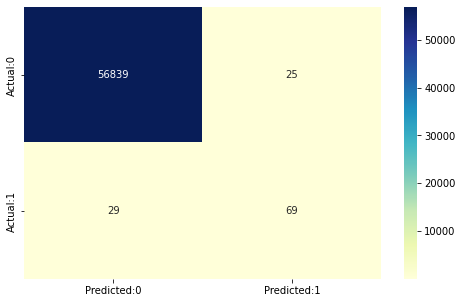

In [116]:
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu");

print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
confusion_matrix(y_test,y_pred)

In [117]:
TP = cm[1,1] # true positive 
TN = cm[0,0] # true negatives
FP = cm[0,1] # false positives
FN = cm[1,0] # false negatives

In [ ]:
print("Sensitivity:-",TP / float(TP+FN))
print("Specificity:-", TN / float(TN+FP))
print("Precsison:-", TP / float(TP+FP))
print("F1-Score:-", f1_score(y_test, y_pred))

Sensitivity:- 0.673469387755102
Specificity:- 0.9996013881072969
Precsison:- 0.7443609022556391
F1-Score:- 0.7071428571428572


##Random Forest

0.9995962220427653
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.97      0.79      0.87        98

    accuracy                           1.00     56962
   macro avg       0.99      0.89      0.93     56962
weighted avg       1.00      1.00      1.00     56962



array([[56862,     2],
       [   21,    77]])

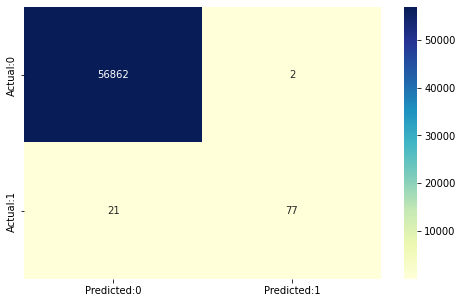

In [118]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier()
random_forest.fit(X_train,y_train.values.ravel())
y_pred = random_forest.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu");
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
confusion_matrix(y_test,y_pred)

In [119]:
TP = cm[1,1] # true positive 
TN = cm[0,0] # true negatives
FP = cm[0,1] # false positives
FN = cm[1,0] # false negatives
print("Sensitivity:-",TP / float(TP+FN))
print("Specificity:-", TN / float(TN+FP))
print("Precsison:-", TP / float(TP+FP))
print("F1-Score:-", f1_score(y_test, y_pred))

Sensitivity:- 0.7857142857142857
Specificity:- 0.9999648283624085
Precsison:- 0.9746835443037974
F1-Score:- 0.8700564971751412


In [120]:
y_test_pred_proba = random_forest.predict_proba(X_test)[:,1]
auc = metrics.roc_auc_score(y_test, y_test_pred_proba)
auc

0.9475858259736083

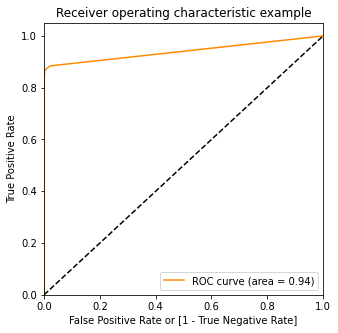

In [ ]:
draw_roc(y_test, y_test_pred_proba)

##Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

folds = KFold(n_splits=5, shuffle=True, random_state=4)

# Specify params
params = {"C": [0.01, 0.1, 1, 10, 100, 1000]}

# Specifing score as recall as we are more focused on acheiving the higher sensitivity than the accuracy
model_cv = GridSearchCV(estimator = LogisticRegression(),
                        param_grid = params, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True) 

# Fit the model
model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [ ]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.903285,0.024160,0.028800,0.001799,0.01,{'C': 0.01},0.987967,0.985494,0.972633,0.951748,0.990285,0.977626,0.014309,1,0.982512,0.982766,0.980043,0.987291,0.979744,0.982471,0.002707
1,1.336198,0.057298,0.027871,0.000652,0.1,{'C': 0.1},0.985269,0.979670,0.971300,0.949260,0.989610,0.975022,0.014261,2,0.981847,0.982173,0.977725,0.985928,0.977432,0.981021,0.003157
2,1.464107,0.075014,0.027771,0.000791,1,{'C': 1},0.984152,0.977491,0.971000,0.948576,0.988652,0.973974,0.014038,3,0.981298,0.981712,0.977015,0.985166,0.976493,0.980337,0.003223
3,1.492716,0.058400,0.027404,0.000299,10,{'C': 10},0.983999,0.977233,0.970979,0.948506,0.988507,0.973845,0.013999,4,0.981225,0.981651,0.976929,0.985070,0.976380,0.980251,0.003229
4,1.467014,0.070557,0.027255,0.000204,100,{'C': 100},0.983983,0.977213,0.970979,0.948498,0.988491,0.973833,0.013995,5,0.981218,0.981642,0.976919,0.985059,0.976366,0.980241,0.003231
5,1.465682,0.086304,0.027658,0.000513,1000,{'C': 1000},0.983983,0.977208,0.970979,0.948497,0.988489,0.973831,0.013995,6,0.981217,0.981642,0.976918,0.985057,0.976364,0.980240,0.003230


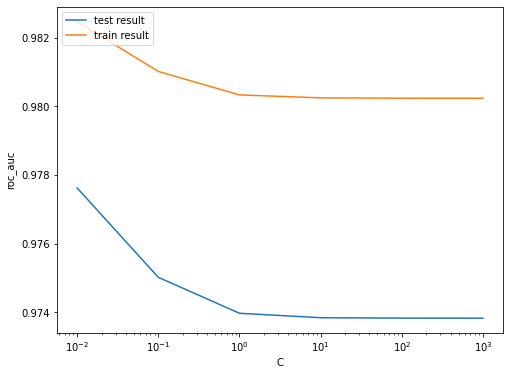

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(cv_results['param_C'], cv_results['mean_test_score'])
plt.plot(cv_results['param_C'], cv_results['mean_train_score'])
plt.xlabel('C')
plt.ylabel('roc_auc')
plt.legend(['test result', 'train result'], loc='upper left')
plt.xscale('log')

In [ ]:
Counter(y_test)

Counter({0: 85296, 1: 147})

In [ ]:
# Best score with best C
best_score = model_cv.best_score_
best_C = model_cv.best_params_['C']

print(" The highest test roc_auc is {0} at C = {1}".format(best_score, best_C))

 The highest test roc_auc is 0.9776255886854004 at C = 0.01


0.9985955549313578
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.82      0.23      0.37        98

    accuracy                           1.00     56962
   macro avg       0.91      0.62      0.68     56962
weighted avg       1.00      1.00      1.00     56962



array([[56859,     5],
       [   75,    23]])

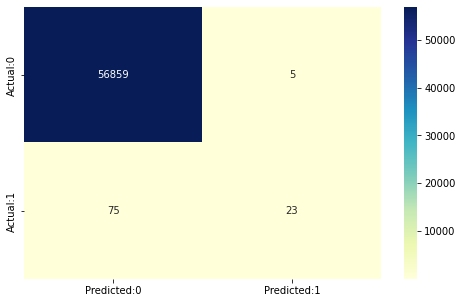

In [134]:

model = LogisticRegression(C=0.0001)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu");
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
confusion_matrix(y_test,y_pred)

In [123]:
y_test_pred = model.predict(X_test)

In [124]:
y_test_pred_proba = model.predict_proba(X_test)[:,1]
auc = metrics.roc_auc_score(y_test_pred, y_test_pred_proba)
auc

0.9999999999999999

In [125]:
TP = cm[1,1] # true positive 
TN = cm[0,0] # true negatives
FP = cm[0,1] # false positives
FN = cm[1,0] # false negatives

In [126]:
print("Sensitivity:-",TP / float(TP+FN))
print("Specificity:-", TN / float(TN+FP))
print("Precsison:-", TP / float(TP+FP))
print("F1-Score:-", f1_score(y_test, y_test_pred))


Sensitivity:- 0.23469387755102042
Specificity:- 0.9999120709060214
Precsison:- 0.8214285714285714
F1-Score:- 0.3650793650793651


##K-Nearest neighbour

0.9995435553526912
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.79      0.86        98

    accuracy                           1.00     56962
   macro avg       0.97      0.89      0.93     56962
weighted avg       1.00      1.00      1.00     56962



array([[56859,     5],
       [   21,    77]])

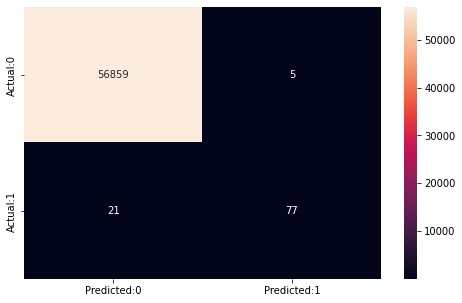

In [127]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors =5)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True, fmt='g');
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
confusion_matrix(y_test,y_pred)

In [128]:
TP = cm[1,1] # true positive 
TN = cm[0,0] # true negatives
FP = cm[0,1] # false positives
FN = cm[1,0] # false negatives
print("Sensitivity:-",TP / float(TP+FN))
print("Specificity:-", TN / float(TN+FP))
print("Precsison:-", TP / float(TP+FP))
print("F1-Score:-", f1_score(y_test, y_pred))

Sensitivity:- 0.7857142857142857
Specificity:- 0.9999120709060214
Precsison:- 0.9390243902439024
F1-Score:- 0.8555555555555556


##Naive Bayes Gaussian

0.977599101155156
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.81      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.89      0.55     56962
weighted avg       1.00      0.98      0.99     56962



array([[55607,  1257],
       [   19,    79]])

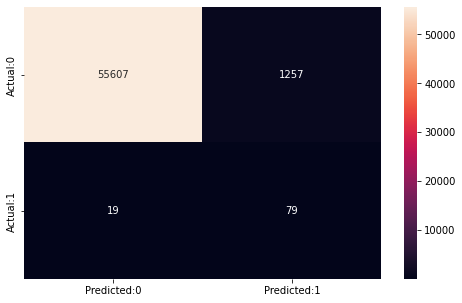

In [135]:
from sklearn.naive_bayes import GaussianNB  
classifier = GaussianNB()  
classifier.fit(X_train, y_train) 
y_pred = classifier.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True, fmt='g');
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
confusion_matrix(y_test,y_pred)

In [131]:
TP = cm[1,1] # true positive 
TN = cm[0,0] # true negatives
FP = cm[0,1] # false positives
FN = cm[1,0] # false negatives
print("Sensitivity:-",TP / float(TP+FN))
print("Specificity:-", TN / float(TN+FP))
print("Precsison:-", TP / float(TP+FP))
print("F1-Score:-", f1_score(y_test, y_pred))

Sensitivity:- 0.8061224489795918
Specificity:- 0.9778946257737761
Precsison:- 0.05913173652694611
F1-Score:- 0.1101813110181311


In [132]:
y_test_pred_proba = classifier.predict_proba(X_test)[:,1]
auc = metrics.roc_auc_score(y_test, y_test_pred_proba)
auc

0.9701312045639865

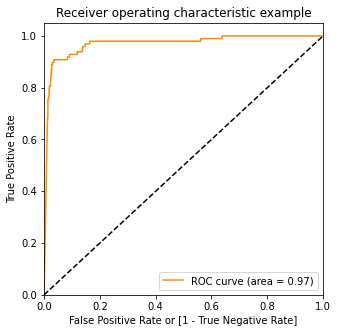

In [133]:
draw_roc(y_test, y_test_pred_proba)

#SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='minority', random_state=0)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


In [ ]:
print('Before sampling class distribution:-',Counter(y_train))
# new class distribution 
print('New class distribution:-',Counter(y_train_smote))

Before sampling class distribution:- Counter({0: 227451, 1: 394})
New class distribution:- Counter({0: 227451, 1: 227451})


In [ ]:
# X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_train_smote, y_train_smote, test_size = 0.2, random_state=42)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


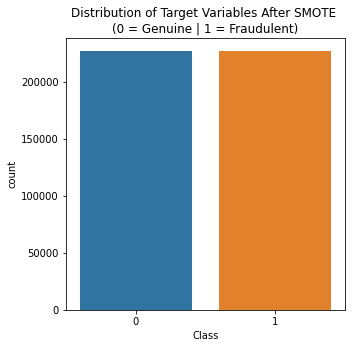

In [ ]:
plt.figure(figsize=(5,5))
plt.title('Distribution of Target Variables After SMOTE \n(0 = Genuine | 1 = Fraudulent)')
sns.countplot(y_train_smote);

0.9843931041747129
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.09      0.91      0.17        98

    accuracy                           0.98     56962
   macro avg       0.55      0.95      0.58     56962
weighted avg       1.00      0.98      0.99     56962



array([[55984,   880],
       [    9,    89]])

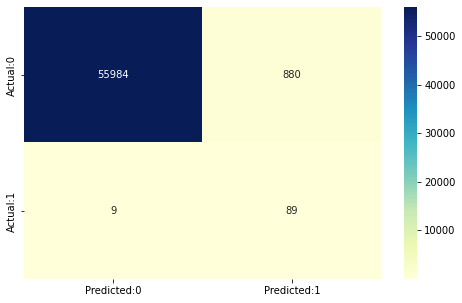

In [ ]:
model = LogisticRegression(C=0.0001)
logi_model=model.fit(X_train_smote,y_train_smote)
y_pred = logi_model.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu");
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
confusion_matrix(y_test,y_pred)



In [ ]:
TP = cm[1,1] # true positive 
TN = cm[0,0] # true negatives
FP = cm[0,1] # false positives
FN = cm[1,0] # false negatives
print("Sensitivity:-",TP / float(TP+FN))
print("Precsison:-", TP / float(TP+FP))
print("F1-Score:-", f1_score(y_test, y_pred))
print("TPR:-", TP / float(TP+FN))
print("FPR:-", FP / float(FP+TN))


Sensitivity:- 0.8571428571428571
Precsison:- 0.9130434782608695
F1-Score:- 0.8842105263157894
TPR:- 0.8571428571428571
FPR:- 0.00014068655036578504


0.9620975387100172
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56864
           1       0.04      0.87      0.07        98

    accuracy                           0.96     56962
   macro avg       0.52      0.91      0.53     56962
weighted avg       1.00      0.96      0.98     56962



array([[54718,  2146],
       [   13,    85]])

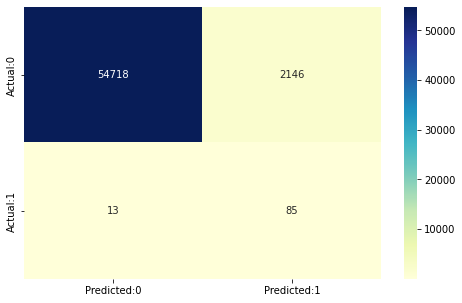

In [ ]:
decision_tree = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=5, 
                                  min_samples_leaf=100,
                                  min_samples_split=100)
decision_tree.fit(X_train_smote,y_train_smote)

y_pred = decision_tree.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu");
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
confusion_matrix(y_test,y_pred)

In [ ]:
TP = cm[1,1] # true positive 
TN = cm[0,0] # true negatives
FP = cm[0,1] # false positives
FN = cm[1,0] # false negatives
print("Sensitivity:-",TP / float(TP+FN))
print("Precsison:-", TP / float(TP+FP))
print("F1-Score:-", f1_score(y_test, y_pred))
print("TPR:-", TP / float(TP+FN))
print("FPR:-", FP / float(FP+TN))


Sensitivity:- 0.8673469387755102
Precsison:- 0.03809950694755715
F1-Score:- 0.07299270072992702
TPR:- 0.8673469387755102
FPR:- 0.03773916713562184


0.9996137776061234
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.91      0.86      0.88        98

    accuracy                           1.00     56962
   macro avg       0.96      0.93      0.94     56962
weighted avg       1.00      1.00      1.00     56962



array([[56856,     8],
       [   14,    84]])

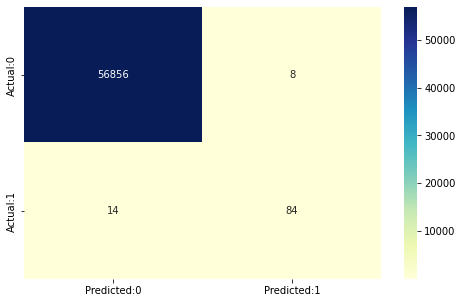

In [ ]:
random_forest = RandomForestClassifier(n_estimators=50, criterion='entropy',random_state=100)
random_forest.fit(X_train_smote,y_train_smote)
y_pred = random_forest.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu");
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
confusion_matrix(y_test,y_pred)


In [ ]:
TP = cm[1,1] # true positive 
TN = cm[0,0] # true negatives
FP = cm[0,1] # false positives
FN = cm[1,0] # false negatives
print("Sensitivity:-",TP / float(TP+FN))
print("Precsison:-", TP / float(TP+FP))
print("F1-Score:-", f1_score(y_test, y_pred))
print("TPR:-", TP / float(TP+FN))
print("FPR:-", FP / float(FP+TN))

Sensitivity:- 0.8469387755102041
Precsison:- 0.9222222222222223
F1-Score:- 0.8829787234042554
TPR:- 0.8469387755102041
FPR:- 0.0001231007315700619


0.9980864435939749
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.47      0.88      0.61        98

    accuracy                           1.00     56962
   macro avg       0.73      0.94      0.81     56962
weighted avg       1.00      1.00      1.00     56962



array([[56767,    97],
       [   12,    86]])

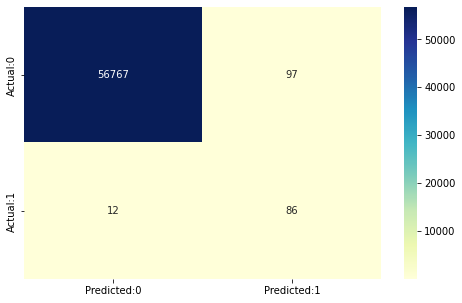

In [ ]:
knn = KNeighborsClassifier(n_neighbors =5)
knn.fit(X_train_smote, y_train_smote)
y_pred = knn.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu");
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
confusion_matrix(y_test,y_pred)

In [ ]:
TP = cm[1,1] # true positive 
TN = cm[0,0] # true negatives
FP = cm[0,1] # false positives
FN = cm[1,0] # false negatives
print("Sensitivity:-",TP / float(TP+FN))
print("Precsison:-", TP / float(TP+FP))
print("F1-Score:-", f1_score(y_test, y_pred))
print("TPR:-", TP / float(TP+FN))
print("FPR:-", FP / float(FP+TN))

0.9739475439766863
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.05      0.87      0.10        98

    accuracy                           0.97     56962
   macro avg       0.53      0.92      0.54     56962
weighted avg       1.00      0.97      0.99     56962



array([[55393,  1471],
       [   13,    85]])

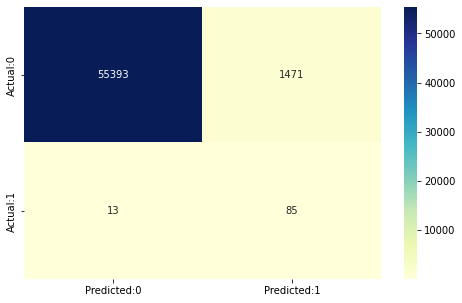

In [ ]:

classifier = GaussianNB()  
classifier.fit(X_train_smote, y_train_smote)
y_pred = classifier.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu");
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
confusion_matrix(y_test,y_pred)

In [ ]:
TP = cm[1,1] # true positive 
TN = cm[0,0] # true negatives
FP = cm[0,1] # false positives
FN = cm[1,0] # false negatives
print("Sensitivity:-",TP / float(TP+FN))
print("Precsison:-", TP / float(TP+FP))
print("F1-Score:-", f1_score(y_test, y_pred))
print("TPR:-", TP / float(TP+FN))
print("FPR:-", FP / float(FP+TN))

Sensitivity:- 0.8673469387755102
Precsison:- 0.05462724935732648
F1-Score:- 0.10278113663845223
TPR:- 0.8673469387755102
FPR:- 0.02586873944850872


# Under Sampling

In [ ]:
from collections import Counter
Counter(y_train)

Counter({0: 227451, 1: 394})

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
rus = RandomUnderSampler(random_state=0)
# resampling X, y
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

In [ ]:
print('Before sampling class distribution:-',Counter(y_train))
# new class distribution 
print('New class distribution:-',Counter(y_train_rus))

Before sampling class distribution:- Counter({0: 227451, 1: 394})
New class distribution:- Counter({0: 394, 1: 394})


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


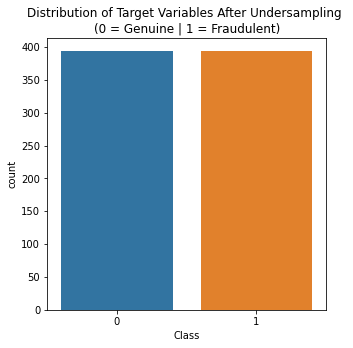

In [ ]:
plt.figure(figsize=(5,5))
plt.title('Distribution of Target Variables After Undersampling \n(0 = Genuine | 1 = Fraudulent)')
sns.countplot(y_train_rus);

0.999403110845827
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.80      0.82        98

    accuracy                           1.00     56962
   macro avg       0.92      0.90      0.91     56962
weighted avg       1.00      1.00      1.00     56962



array([[56850,    14],
       [   20,    78]])

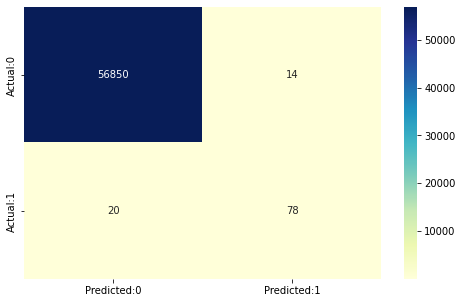

In [ ]:
model = LogisticRegression(C=0.0001)
model.fit(X_train_rus,y_train_rus)
y_pred = model.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu");
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
confusion_matrix(y_test,y_pred)

In [ ]:
TP = cm[1,1] # true positive 
TN = cm[0,0] # true negatives
FP = cm[0,1] # false positives
FN = cm[1,0] # false negatives

In [ ]:
print("Sensitivity:-",TP / float(TP+FN))
print("Precsison:-", TP / float(TP+FP))
print("F1-Score:-", f1_score(y_test, y_pred))
print("TPR:-", TP / float(TP+FN))
print("FPR:-", FP / float(FP+TN))

Sensitivity:- 0.7959183673469388
Precsison:- 0.8478260869565217
F1-Score:- 0.8210526315789473
TPR:- 0.7959183673469388
FPR:- 0.0002462014631401238


0.9840068817808364
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.08      0.83      0.15        98

    accuracy                           0.98     56962
   macro avg       0.54      0.91      0.57     56962
weighted avg       1.00      0.98      0.99     56962



array([[55970,   894],
       [   17,    81]])

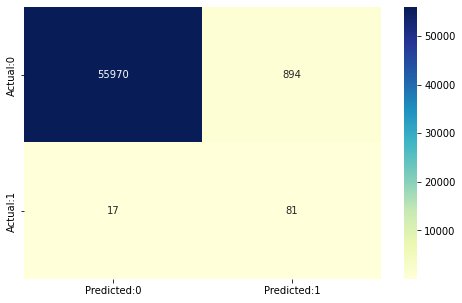

In [ ]:
decision_tree = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=5, 
                                  min_samples_leaf=100,
                                  min_samples_split=100)
decision_tree.fit(X_train_rus,y_train_rus)

y_pred = decision_tree.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu");
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
confusion_matrix(y_test,y_pred)

In [ ]:
TP = cm[1,1] # true positive 
TN = cm[0,0] # true negatives
FP = cm[0,1] # false positives
FN = cm[1,0] # false negatives
print("Sensitivity:-",TP / float(TP+FN))
print("Precsison:-", TP / float(TP+FP))
print("F1-Score:-", f1_score(y_test, y_pred))
print("TPR:-", TP / float(TP+FN))
print("FPR:-", FP / float(FP+TN))

Sensitivity:- 0.826530612244898
Precsison:- 0.08307692307692308
F1-Score:- 0.15097856477166824
TPR:- 0.826530612244898
FPR:- 0.015721722003376477


0.9860959938204417
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.10      0.91      0.18        98

    accuracy                           0.99     56962
   macro avg       0.55      0.95      0.59     56962
weighted avg       1.00      0.99      0.99     56962



array([[56081,   783],
       [    9,    89]])

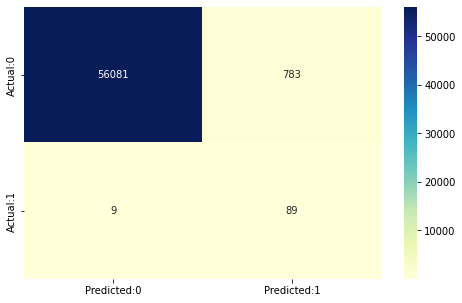

In [ ]:
random_forest = RandomForestClassifier(n_estimators=50, criterion='entropy',random_state=100)
random_forest.fit(X_train_rus,y_train_rus)
y_pred = random_forest.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu");
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
confusion_matrix(y_test,y_pred)

In [ ]:
TP = cm[1,1] # true positive 
TN = cm[0,0] # true negatives
FP = cm[0,1] # false positives
FN = cm[1,0] # false negatives
print("Sensitivity:-",TP / float(TP+FN))
print("Precsison:-", TP / float(TP+FP))
print("F1-Score:-", f1_score(y_test, y_pred))
print("TPR:-", TP / float(TP+FN))
print("FPR:-", FP / float(FP+TN))

Sensitivity:- 0.9081632653061225
Precsison:- 0.10206422018348624
F1-Score:- 0.18350515463917524
TPR:- 0.9081632653061225
FPR:- 0.01376969611705121


0.9774059899582178
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.07      0.91      0.12        98

    accuracy                           0.98     56962
   macro avg       0.53      0.94      0.56     56962
weighted avg       1.00      0.98      0.99     56962



array([[55586,  1278],
       [    9,    89]])

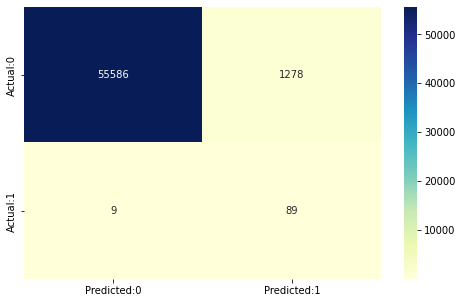

In [ ]:
knn = KNeighborsClassifier(n_neighbors =5)
knn.fit(X_train_rus,y_train_rus)
y_pred = knn.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu");
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
confusion_matrix(y_test,y_pred)


In [ ]:
TP = cm[1,1] # true positive 
TN = cm[0,0] # true negatives
FP = cm[0,1] # false positives
FN = cm[1,0] # false negatives
print("Sensitivity:-",TP / float(TP+FN))
print("Precsison:-", TP / float(TP+FP))
print("F1-Score:-", f1_score(y_test, y_pred))
print("TPR:-", TP / float(TP+FN))
print("FPR:-", FP / float(FP+TN))

Sensitivity:- 0.9081632653061225
Precsison:- 0.06510607168983175
F1-Score:- 0.12150170648464163
TPR:- 0.9081632653061225
FPR:- 0.022474676420934158


0.9693830975035989
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56864
           1       0.05      0.86      0.09        98

    accuracy                           0.97     56962
   macro avg       0.52      0.91      0.54     56962
weighted avg       1.00      0.97      0.98     56962



array([[55134,  1730],
       [   14,    84]])

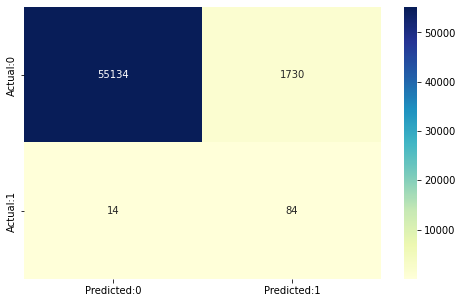

In [ ]:
classifier = GaussianNB()  
classifier.fit(X_train_rus, y_train_rus)
y_pred = classifier.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu");
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
confusion_matrix(y_test,y_pred)



In [ ]:
TP = cm[1,1] # true positive 
TN = cm[0,0] # true negatives
FP = cm[0,1] # false positives
FN = cm[1,0] # false negatives
print("Sensitivity:-",TP / float(TP+FN))
print("Precsison:-", TP / float(TP+FP))
print("F1-Score:-", f1_score(y_test, y_pred))
print("TPR:-", TP / float(TP+FN))
print("FPR:-", FP / float(FP+TN))

Sensitivity:- 0.8571428571428571
Precsison:- 0.04630650496141125
F1-Score:- 0.0878661087866109
TPR:- 0.8571428571428571
FPR:- 0.03042346651660101


#AdaSyn (Adaptive Synthetic Sampling)

In [ ]:
from imblearn.over_sampling import ADASYN

In [ ]:
X_train.shape

(227845, 30)

In [ ]:
ada = ADASYN(random_state=0)
X_train_adasyn, y_train_adasyn = ada.fit_resample(X_train, y_train)

# Befor sampling class distribution
print('Before sampling class distribution:-',Counter(y_train))
# new class distribution 
print('New class distribution:-',Counter(y_train_adasyn))

Before sampling class distribution:- Counter({0: 227451, 1: 394})
New class distribution:- Counter({1: 227462, 0: 227451})


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


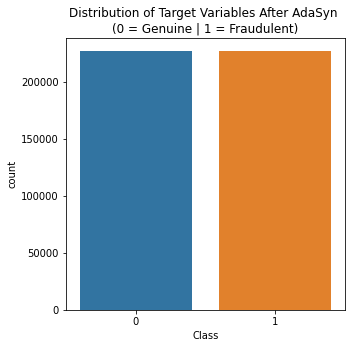

In [ ]:
plt.figure(figsize=(5,5))
plt.title('Distribution of Target Variables After AdaSyn \n(0 = Genuine | 1 = Fraudulent)')
sns.countplot(y_train_adasyn);

0.9249148555177136
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     56864
           1       0.02      0.94      0.04        98

    accuracy                           0.92     56962
   macro avg       0.51      0.93      0.50     56962
weighted avg       1.00      0.92      0.96     56962



array([[52593,  4271],
       [    6,    92]])

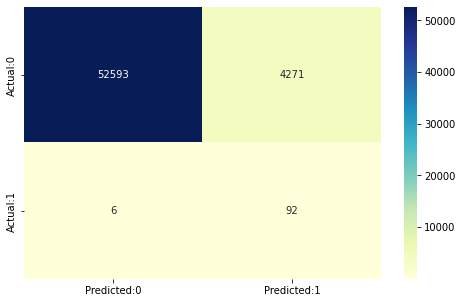

In [ ]:
model = LogisticRegression(C=0.0001)
model.fit(X_train_adasyn, y_train_adasyn)
y_pred = model.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu");
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
confusion_matrix(y_test,y_pred)


In [ ]:
TP = cm[1,1] # true positive 
TN = cm[0,0] # true negatives
FP = cm[0,1] # false positives
FN = cm[1,0] # false negatives
print("Sensitivity:-",TP / float(TP+FN))
print("Precsison:-", TP / float(TP+FP))
print("F1-Score:-", f1_score(y_test, y_pred))
print("TPR:-", TP / float(TP+FN))
print("FPR:-", FP / float(FP+TN))

Sensitivity:- 0.9387755102040817
Precsison:- 0.021086408434563372
F1-Score:- 0.04124635731898677
TPR:- 0.9387755102040817
FPR:- 0.07510903207653348


0.8780239457884204
              precision    recall  f1-score   support

           0       1.00      0.88      0.93     56864
           1       0.01      0.94      0.03        98

    accuracy                           0.88     56962
   macro avg       0.51      0.91      0.48     56962
weighted avg       1.00      0.88      0.93     56962



array([[49922,  6942],
       [    6,    92]])

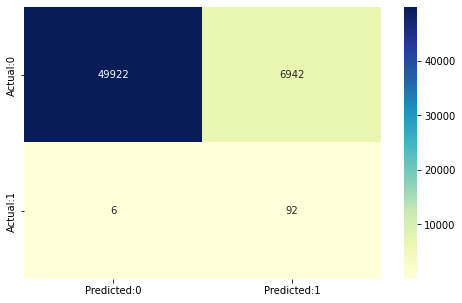

In [ ]:
decision_tree = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=5, 
                                  min_samples_leaf=100,
                                  min_samples_split=50)
decision_tree.fit(X_train_adasyn, y_train_adasyn)

y_pred = decision_tree.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu");
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
confusion_matrix(y_test,y_pred)

In [ ]:
TP = cm[1,1] # true positive 
TN = cm[0,0] # true negatives
FP = cm[0,1] # false positives
FN = cm[1,0] # false negatives
print("Sensitivity:-",TP / float(TP+FN))
print("Precsison:-", TP / float(TP+FP))
print("F1-Score:-", f1_score(y_test, y_pred))
print("TPR:-", TP / float(TP+FN))
print("FPR:-", FP / float(FP+TN))

Sensitivity:- 0.9387755102040817
Precsison:- 0.013079328973557009
F1-Score:- 0.02579921480650589
TPR:- 0.9387755102040817
FPR:- 0.12208075407990997


0.9995259997893332
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.90      0.82      0.86        98

    accuracy                           1.00     56962
   macro avg       0.95      0.91      0.93     56962
weighted avg       1.00      1.00      1.00     56962



array([[56855,     9],
       [   18,    80]])

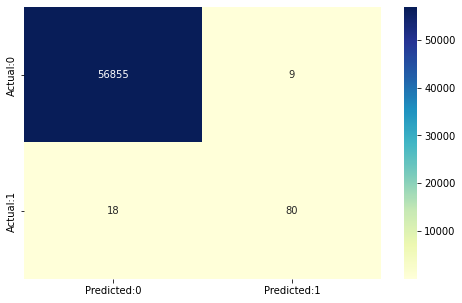

In [ ]:
random_forest = RandomForestClassifier(n_estimators=50, criterion='entropy',random_state=100)
random_forest.fit(X_train_adasyn, y_train_adasyn)
y_pred = random_forest.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu");
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
confusion_matrix(y_test,y_pred)


In [ ]:
TP = cm[1,1] # true positive 
TN = cm[0,0] # true negatives
FP = cm[0,1] # false positives
FN = cm[1,0] # false negatives
print("Sensitivity:-",TP / float(TP+FN))
print("Precsison:-", TP / float(TP+FP))
print("F1-Score:-", f1_score(y_test, y_pred))
print("TPR:-", TP / float(TP+FN))
print("FPR:-", FP / float(FP+TN))

Sensitivity:- 0.8163265306122449
Precsison:- 0.898876404494382
F1-Score:- 0.8556149732620321
TPR:- 0.8163265306122449
FPR:- 0.00015827236916150816


0.9980864435939749
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.47      0.87      0.61        98

    accuracy                           1.00     56962
   macro avg       0.73      0.93      0.80     56962
weighted avg       1.00      1.00      1.00     56962



array([[56768,    96],
       [   13,    85]])

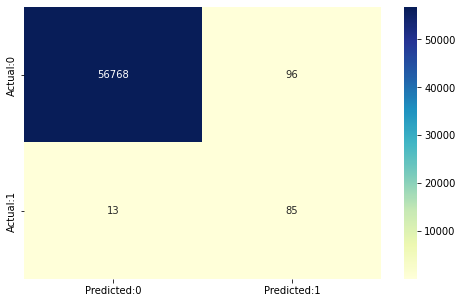

In [ ]:
knn = KNeighborsClassifier(n_neighbors =5)
knn.fit(X_train_adasyn, y_train_adasyn)
y_pred = knn.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu");
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
confusion_matrix(y_test,y_pred)

In [ ]:
TP = cm[1,1] # true positive 
TN = cm[0,0] # true negatives
FP = cm[0,1] # false positives
FN = cm[1,0] # false negatives
print("Sensitivity:-",TP / float(TP+FN))
print("Precsison:-", TP / float(TP+FP))
print("F1-Score:-", f1_score(y_test, y_pred))
print("TPR:-", TP / float(TP+FN))
print("FPR:-", FP / float(FP+TN))

Sensitivity:- 0.8673469387755102
Precsison:- 0.4696132596685083
F1-Score:- 0.6093189964157706
TPR:- 0.8673469387755102
FPR:- 0.0016882386043894203


0.958849759488782
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56864
           1       0.04      0.91      0.07        98

    accuracy                           0.96     56962
   macro avg       0.52      0.93      0.52     56962
weighted avg       1.00      0.96      0.98     56962



array([[54529,  2335],
       [    9,    89]])

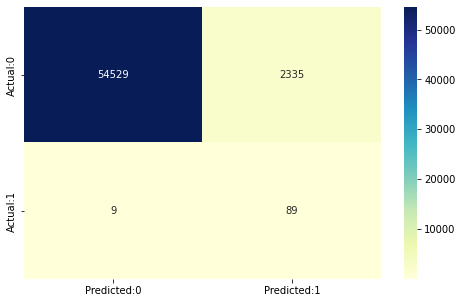

In [ ]:
classifier = GaussianNB()  
classifier.fit(X_train_adasyn, y_train_adasyn)
y_pred = classifier.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu");
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
confusion_matrix(y_test,y_pred)

In [ ]:
TP = cm[1,1] # true positive 
TN = cm[0,0] # true negatives
FP = cm[0,1] # false positives
FN = cm[1,0] # false negatives
print("Sensitivity:-",TP / float(TP+FN))
print("Precsison:-", TP / float(TP+FP))
print("F1-Score:-", f1_score(y_test, y_pred))
print("TPR:-", TP / float(TP+FN))
print("FPR:-", FP / float(FP+TN))

Sensitivity:- 0.9081632653061225
Precsison:- 0.036716171617161716
F1-Score:- 0.07057890563045202
TPR:- 0.9081632653061225
FPR:- 0.0410628868880135


# Over Sampling

In [ ]:

from imblearn.over_sampling import RandomOverSampler


In [ ]:
ros = RandomOverSampler()
# resampling X, y
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X_train_ros, y_train_ros, test_size = 0.3)

In [ ]:
print('Before sampling class distribution:-',Counter(y_train))
# new class distribution 
print('New class distribution:-',Counter(y_train_ros))

Before sampling class distribution:- Counter({0: 227451, 1: 394})
New class distribution:- Counter({0: 227451, 1: 227451})


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


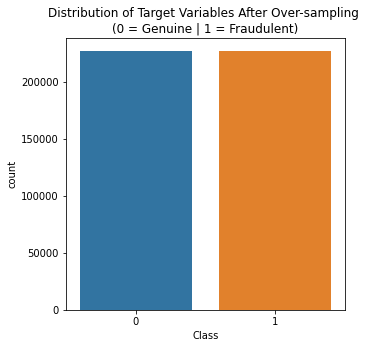

In [ ]:
plt.figure(figsize=(5,5))
plt.title('Distribution of Target Variables After Over-sampling \n(0 = Genuine | 1 = Fraudulent)')
sns.countplot(y_train_ros);

0.9796882131947614
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.07      0.93      0.14        98

    accuracy                           0.98     56962
   macro avg       0.54      0.95      0.56     56962
weighted avg       1.00      0.98      0.99     56962



array([[55714,  1150],
       [    7,    91]])

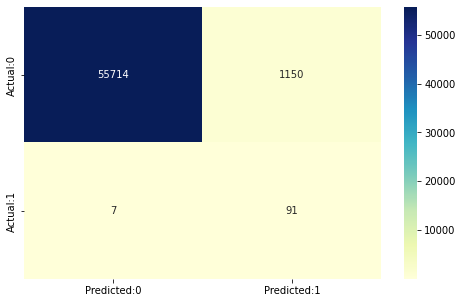

In [ ]:
model = LogisticRegression(C=0.001)
model.fit(X_train_ros,y_train_ros)
y_pred = model.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu");
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
confusion_matrix(y_test,y_pred)

In [ ]:
TP = cm[1,1] # true positive 
TN = cm[0,0] # true negatives
FP = cm[0,1] # false positives
FN = cm[1,0] # false negatives
print("Sensitivity:-",TP / float(TP+FN))
print("Precsison:-", TP / float(TP+FP))
print("F1-Score:-", f1_score(y_test, y_pred))
print("TPR:-", TP / float(TP+FN))
print("FPR:-", FP / float(FP+TN))

Sensitivity:- 0.9285714285714286
Precsison:- 0.07332796132151491
F1-Score:- 0.13592233009708737
TPR:- 0.9285714285714286
FPR:- 0.0202236916150816


0.9620799831466592
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56864
           1       0.04      0.86      0.07        98

    accuracy                           0.96     56962
   macro avg       0.52      0.91      0.53     56962
weighted avg       1.00      0.96      0.98     56962



array([[54718,  2146],
       [   14,    84]])

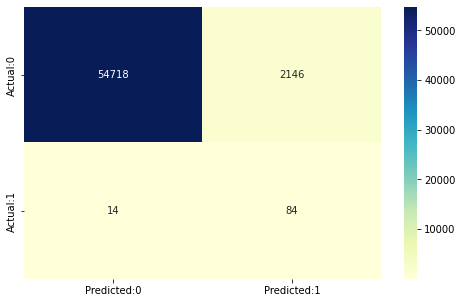

In [ ]:
decision_tree = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=5, 
                                  min_samples_leaf=100,
                                  min_samples_split=100)
decision_tree.fit(X_train_ros,y_train_ros)

y_pred = decision_tree.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu");
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
confusion_matrix(y_test,y_pred)

In [ ]:
TP = cm[1,1] # true positive 
TN = cm[0,0] # true negatives
FP = cm[0,1] # false positives
FN = cm[1,0] # false negatives
print("Sensitivity:-",TP / float(TP+FN))
print("Precsison:-", TP / float(TP+FP))
print("F1-Score:-", f1_score(y_test, y_pred))
print("TPR:-", TP / float(TP+FN))
print("FPR:-", FP / float(FP+TN))

Sensitivity:- 0.8571428571428571
Precsison:- 0.03766816143497758
F1-Score:- 0.07216494845360825
TPR:- 0.8571428571428571
FPR:- 0.03773916713562184


0.9996488887328394
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.99      0.81      0.89        98

    accuracy                           1.00     56962
   macro avg       0.99      0.90      0.94     56962
weighted avg       1.00      1.00      1.00     56962



array([[56863,     1],
       [   19,    79]])

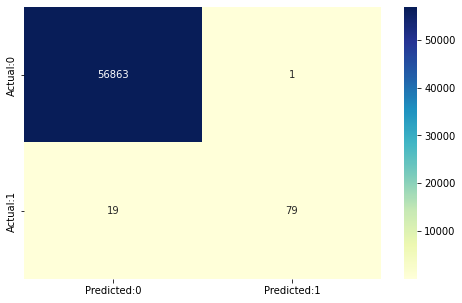

In [ ]:
random_forest = RandomForestClassifier(n_estimators=50, criterion='entropy',random_state=100)
random_forest.fit(X_train_ros,y_train_ros)
y_pred = random_forest.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu");
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
confusion_matrix(y_test,y_pred)

In [ ]:
TP = cm[1,1] # true positive 
TN = cm[0,0] # true negatives
FP = cm[0,1] # false positives
FN = cm[1,0] # false negatives
print("Sensitivity:-",TP / float(TP+FN))
print("Precsison:-", TP / float(TP+FP))
print("F1-Score:-", f1_score(y_test, y_pred))
print("TPR:-", TP / float(TP+FN))
print("FPR:-", FP / float(FP+TN))

Sensitivity:- 0.8061224489795918
Precsison:- 0.9875
F1-Score:- 0.8876404494382023
TPR:- 0.8061224489795918
FPR:- 1.758581879572313e-05


0.9991573329588147
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.71      0.87      0.78        98

    accuracy                           1.00     56962
   macro avg       0.85      0.93      0.89     56962
weighted avg       1.00      1.00      1.00     56962



array([[56829,    35],
       [   13,    85]])

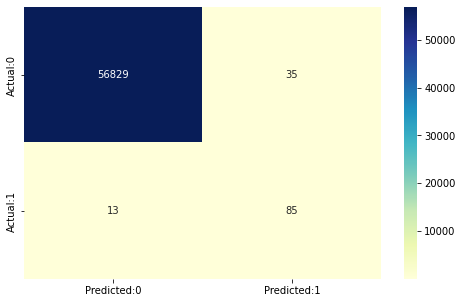

In [ ]:
knn = KNeighborsClassifier(n_neighbors =5)
knn.fit(X_train_ros,y_train_ros)
y_pred = knn.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu");
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
confusion_matrix(y_test,y_pred)


In [ ]:
TP = cm[1,1] # true positive 
TN = cm[0,0] # true negatives
FP = cm[0,1] # false positives
FN = cm[1,0] # false negatives
print("Sensitivity:-",TP / float(TP+FN))
print("Precsison:-", TP / float(TP+FP))
print("F1-Score:-", f1_score(y_test, y_pred))
print("TPR:-", TP / float(TP+FN))
print("FPR:-", FP / float(FP+TN))
TP
TN
FP
FN

Sensitivity:- 0.8673469387755102
Precsison:- 0.7083333333333334
F1-Score:- 0.7798165137614678
TPR:- 0.8673469387755102
FPR:- 0.0006155036578503095


13

0.9734910993293775
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.05      0.87      0.10        98

    accuracy                           0.97     56962
   macro avg       0.53      0.92      0.54     56962
weighted avg       1.00      0.97      0.99     56962



array([[55367,  1497],
       [   13,    85]])

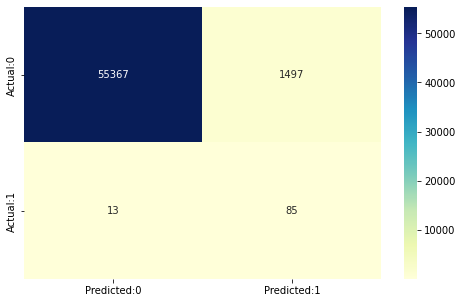

In [ ]:
classifier = GaussianNB()  
classifier.fit(X_train_ros, y_train_ros)
y_pred = classifier.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu");
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
confusion_matrix(y_test,y_pred)

In [ ]:
TP = cm[1,1] # true positive 
TN = cm[0,0] # true negatives
FP = cm[0,1] # false positives
FN = cm[1,0]
print("Sensitivity:-",TP / float(TP+FN))
print("Precsison:-", TP / float(TP+FP))
print("F1-Score:-", f1_score(y_test, y_pred))
print("TPR:-", TP / float(TP+FN))
print("FPR:-", FP / float(FP+TN))
FP

Sensitivity:- 0.8673469387755102
Precsison:- 0.053729456384323644
F1-Score:- 0.10119047619047618
TPR:- 0.8673469387755102
FPR:- 0.026325970737197522


1497